# [PydanticOutputParser](https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.pydantic.PydanticOutputParser.html)
- PydanticOutputParser 는 LLM의 텍스트 출력을 `Pydantic 모델(BaseModel)` 로 자동 변환해 주는 LangChain의 출력 파서입니다.
- 즉, LLM이 자연어로 응답한 텍스트를 사람이 직접 파싱하지 않고, 자동으로 엄격한 구조화된 데이터(예: JSON → 객체) 로 바꿔줍니다.

## JSON
- JSON (JavaScript Object Notation) 은 데이터를 사람이 읽을 수 있는 텍스트로 표현하면서, 컴퓨터가 쉽게 파싱할 수 있는 경량 데이터 교환 형식입니다.
- 웹에서 서버 ↔ 클라이언트 간 데이터 교환에 널리 사용합니다.
- JavaScript 객체 문법을 기반으로 만들어졌지만, Python, Java, C 등 거의 모든 언어에서 사용 가능합니다.

> JSON 예시 
```json
{
  "name": "Alice",
  "age": 25,
  "city": "Seoul"
}
```

# 예제 

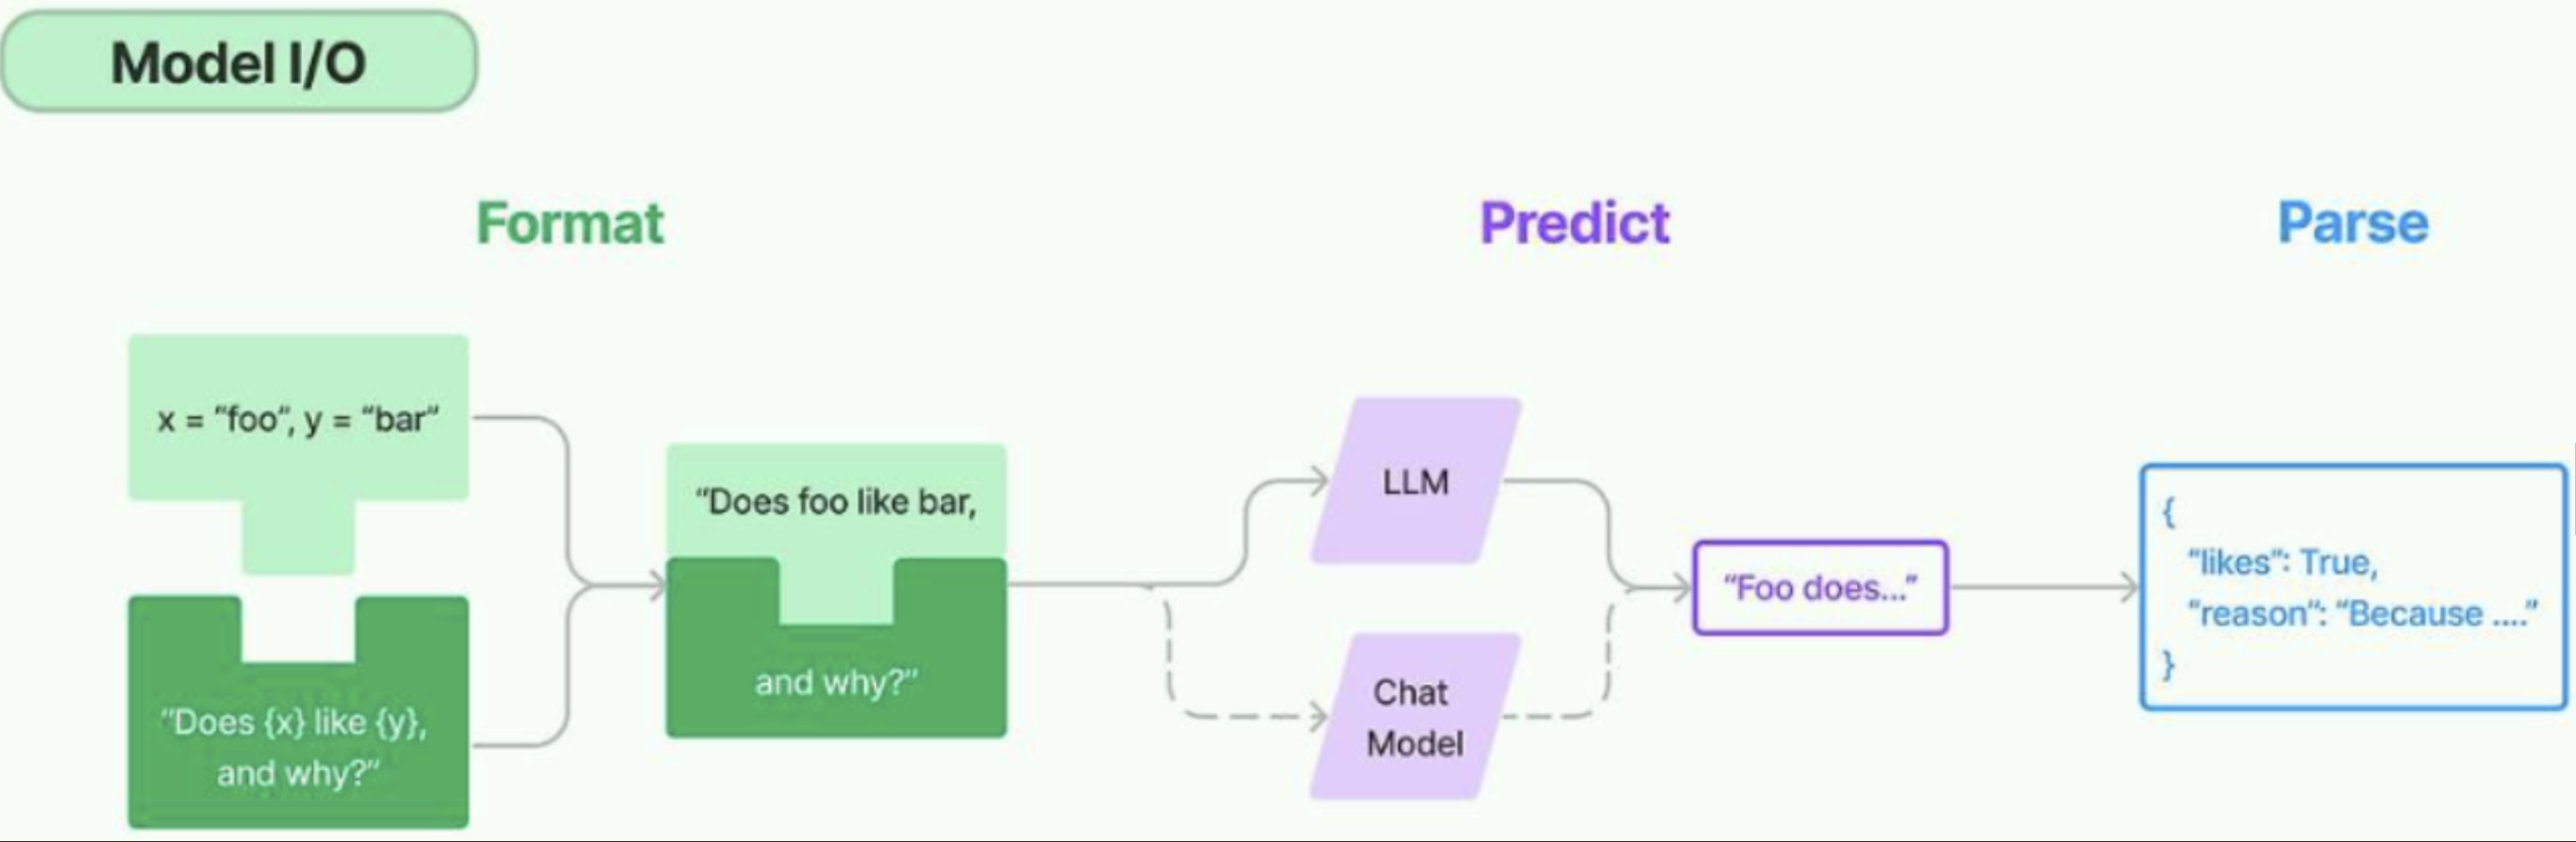

## Parser

In [1]:
from pydantic import BaseModel, Field
from typing import List

# 한국 음식 정보를 위한 Pydantic 모델 정의
class KoreanFood(BaseModel):
    name: str = Field(description="음식 이름")
    category: str = Field(description="음식 카테고리 (예: 밥류, 국물류, 반찬류 등)")
    ingredients: List[str] = Field(description="주요 재료 목록")
    region: str = Field(description="대표적인 지역 (예: 서울, 부산, 전라도 등)")
    taste: str = Field(description="맛의 특징 (예: 매운맛, 단맛, 짠맛 등)")
    description: str = Field(description="음식에 대한 간단한 설명")

In [2]:
from langchain_core.output_parsers import PydanticOutputParser

# Pydantic 출력 파서 초기화
food_parser = PydanticOutputParser(pydantic_object=KoreanFood)


In [3]:
# 출력 형식 지침 가져오기
format_instructions = food_parser.get_format_instructions()

print("출력 형식 지침:")
print(format_instructions)


출력 형식 지침:
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"name": {"description": "음식 이름", "title": "Name", "type": "string"}, "category": {"description": "음식 카테고리 (예: 밥류, 국물류, 반찬류 등)", "title": "Category", "type": "string"}, "ingredients": {"description": "주요 재료 목록", "items": {"type": "string"}, "title": "Ingredients", "type": "array"}, "region": {"description": "대표적인 지역 (예: 서울, 부산, 전라도 등)", "title": "Region", "type": "string"}, "taste": {"description": "맛의 특징 (예: 매운맛, 단맛, 짠맛 등)", "title": "Taste", "type": "string"}, "description": {"description": "음식에 대한 간단한 설명", "title": 

## Prompt

In [4]:
from langchain.prompts import PromptTemplate

# 한국 음식 정보 추출을 위한 프롬프트 템플릿
food_prompt = PromptTemplate(
    template="""
    다음 한국 음식에 대한 정보를 자세히 분석해서 구조화된 형태로 추출해주세요.
    
    음식: {food_name}
    
    {format_instructions}
    
    답변은 반드시 JSON 형식으로 해주세요.
    """,
    input_variables=["food_name"],
    partial_variables={"format_instructions": format_instructions}
)

In [5]:
food_prompt.input_variables

['food_name']

In [6]:
print(food_prompt.template)


    다음 한국 음식에 대한 정보를 자세히 분석해서 구조화된 형태로 추출해주세요.

    음식: {food_name}

    {format_instructions}

    답변은 반드시 JSON 형식으로 해주세요.
    


## Model

### [OpenAI API Key 발급](https://platform.openai.com/api-keys)

In [7]:
from dotenv import load_dotenv

# dotenv 파일에서 환경변수 로드
load_dotenv()

True

In [8]:
import os 

# API 키 확인
api_key = os.getenv("OPENAI_API_KEY")
if api_key:
    print("OpenAI API 키가 설정되었습니다. (GPT 모델 사용)")
else:
    print("OpenAI API 키가 없습니다.")

OpenAI API 키가 설정되었습니다. (GPT 모델 사용)


In [10]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    model="gpt-5-nano",
    reasoning_effort="high",        # 논리성 강화
)

## Chain with Parser
```
사용자 입력 → 프롬프트 구성 → LLM 호출 → 출력 파싱 → 결과 반환
```

In [11]:
# 체인 생성 및 실행
food_chain = food_prompt | model | food_parser

In [12]:
# 김치에 대한 정보 추출
result = food_chain.invoke({"food_name": "김치"})

In [13]:
result

KoreanFood(name='김치', category='반찬류', ingredients=['배추', '소금', '무(선택)', '고춧가루', '다진 마늘', '다진 생강', '대파', '새우젓(또는 멸치액젓)', '설탕(선택)', '찹쌀풀(선택)'], region='한국 전역', taste='매콤하고 새콤하며 짭짤한 맛', description='김치는 한국의 대표 발효식품으로, 배추를 소금에 절이고 매콤한 양념으로 버무려 숙성시킨 반찬이다. 지역과 가족 전통에 따라 재료와 숙성 기간이 다양하다.')

In [14]:
print("김치 정보:")
print(f"이름: {result.name}")
print(f"카테고리: {result.category}")
print(f"재료: {', '.join(result.ingredients)}")
print(f"지역: {result.region}")
print(f"맛: {result.taste}")
print(f"설명: {result.description}")

김치 정보:
이름: 김치
카테고리: 반찬류
재료: 배추, 소금, 무(선택), 고춧가루, 다진 마늘, 다진 생강, 대파, 새우젓(또는 멸치액젓), 설탕(선택), 찹쌀풀(선택)
지역: 한국 전역
맛: 매콤하고 새콤하며 짭짤한 맛
설명: 김치는 한국의 대표 발효식품으로, 배추를 소금에 절이고 매콤한 양념으로 버무려 숙성시킨 반찬이다. 지역과 가족 전통에 따라 재료와 숙성 기간이 다양하다.
